https://towardsdatascience.com/ai-based-indian-license-plate-detector-de9d48ca8951

In [1]:
# # !/opt/conda/bin/python3.7 -m pip install --upgrade pip
# !git clone https://github.com/ultralytics/yolov5  # clone
# !pip install -r yolov5/requirements.txt --use-feature=2020-resolver  # install
#!python yolov5/export.py --img 256 --weights /kaggle/working/best.pt --nms

## 1. Importing necessary libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random
import glob
import torch
import torchvision as tv

## 2. Load train images and show some of them

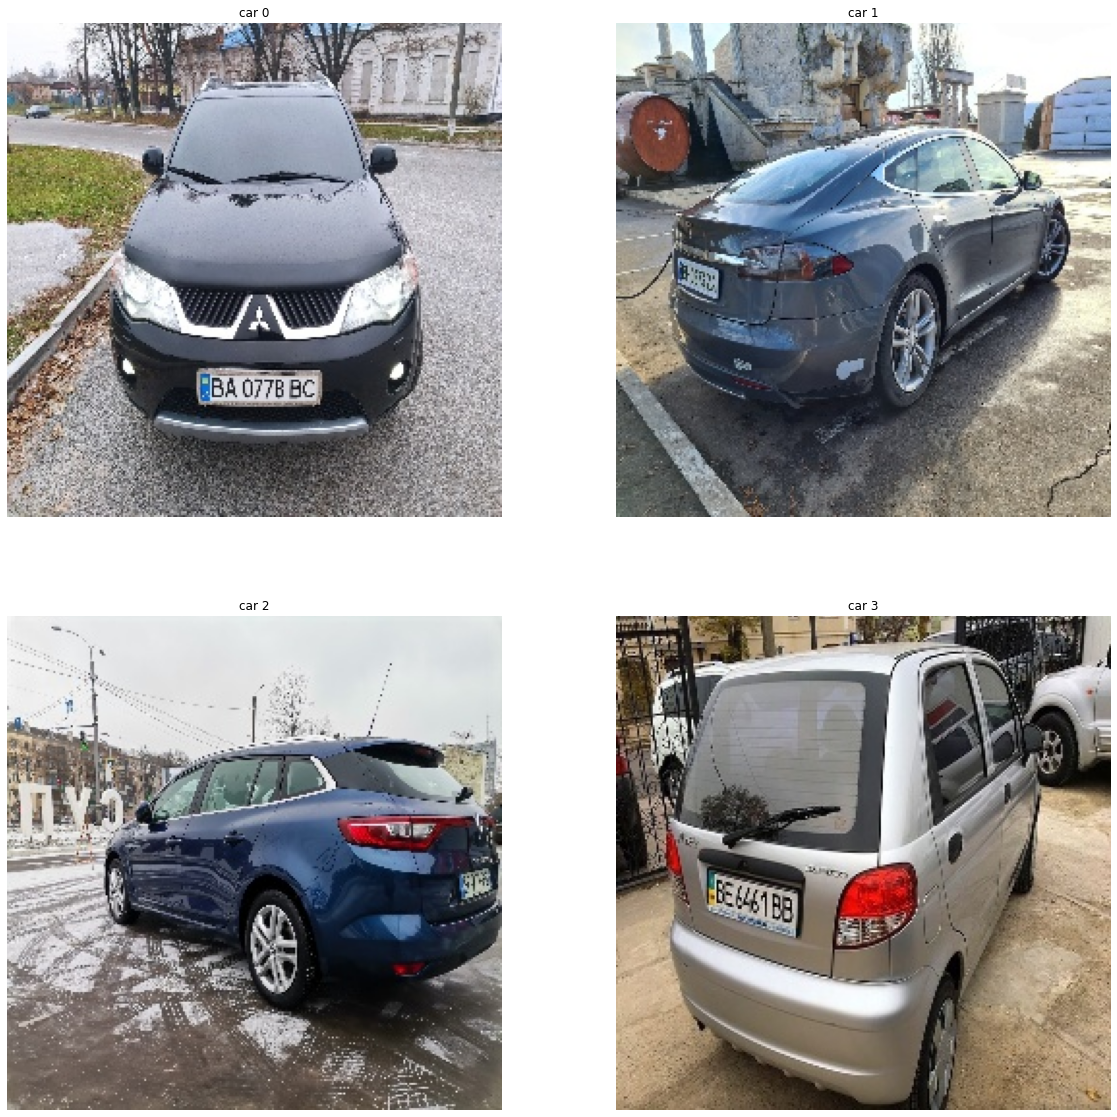

In [3]:
def display(img_, num, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(2, 2, num+1)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)

def display_list(images):
    plt.rcParams["figure.figsize"] = (20, 20)
    for i, img in enumerate(images):
        display(img, i, f'car {i}')
    plt.show()
    
images_globs = [
    '/kaggle/input/yololicenseplates/images/train/*.png',
    '/kaggle/input/yololicenseplates/images/train/*.jpeg',
    '/kaggle/input/yololicenseplates/images/train/*.jpg'
]
# random.seed(235)
car_images = []
for image_glob in images_globs:
    car_images.extend(glob.glob(image_glob))
rnd_images = [cv2.imread(img) for img in random.choices(car_images, k=4)]
display_list(rnd_images)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = torch.hub.load('ultralytics/yolov5', 'custom', path='../input/rusyolov5nlicenseplates/exp/weights/best.pt')
model = model.to(device)

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-10-2 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 213 layers, 1760518 parameters, 0 gradients
Adding AutoShape... 


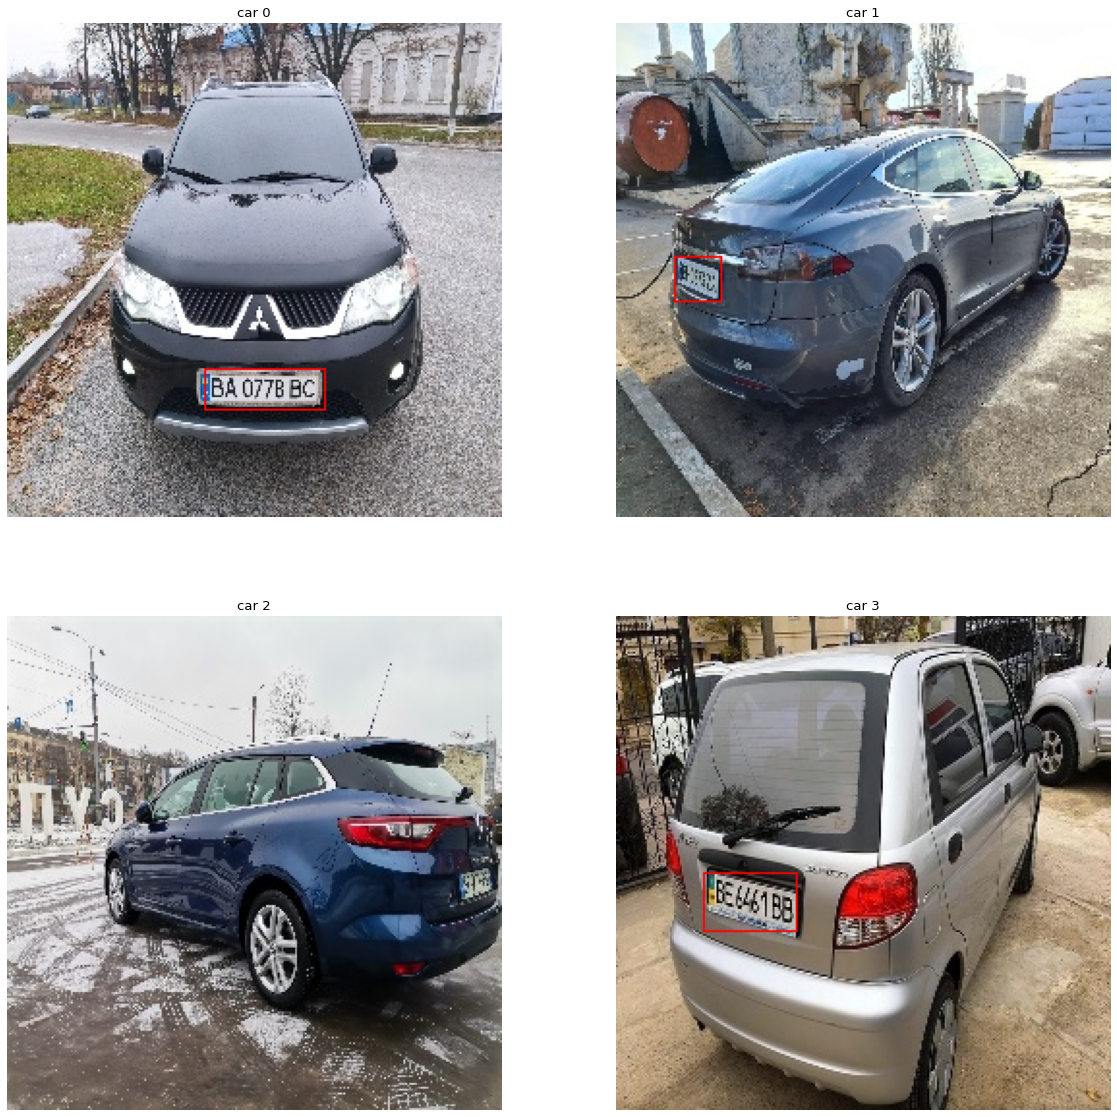

In [5]:
def find_contours(img, model, conf_threshold=0.75, iou_threshold=0.1, width=256, heigth=256):
    
    frame = img.copy()
    img = cv2.resize(img, (width, heigth))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    tensor = torch.from_numpy(img).unsqueeze(0).transpose(1, 3) / 255.0
    preds = model(tensor)[0]
    preds = preds[preds[:, 4] > conf_threshold]
    
    center_x, center_y = preds[:, 0], preds[:, 1]
    box_w, box_h = preds[:, 2], preds[:, 3]
    scores = preds[:, 4]
    preds = torch.stack([
        torch.floor(center_x - box_w / 2),
        torch.floor(center_y - box_h / 2),
        torch.ceil(center_x + box_w / 2),
        torch.ceil(center_y + box_h / 2)
    ], dim=1)
    
    indexes = tv.ops.nms(preds, scores, iou_threshold)
    preds = preds[indexes].cpu().numpy().astype(np.int32).tolist()
    
    boxes = []
    for pred in preds:
        x1, y1, x2, y2 = pred
        nx1, nx2 = int(x1 / width * frame.shape[1]), int(x2 / width * frame.shape[1])
        ny1, ny2 = int(y1 / heigth * frame.shape[0]), int(y2 / heigth * frame.shape[0])
        frame = cv2.rectangle(frame, (ny2, nx1), (ny1, nx2), (0, 0, 255), 1)
        boxes.append((x1 / width, y1/heigth, x2 / width, y2 / heigth))
        
    return frame, boxes

frames = [find_contours(img, model)[0] for img in rnd_images]
display_list(frames)

In [6]:
torch.save(model, 'yoloplates.pt')